---
layout: code-post
title: Training neural nets - Backpropagation
tags: [neural nets]
---

Following our foray into the expressive power of shallow neural
networks, let's train a shallow neural network instead of 
designing them by hand.


Outline:

0. Generating data
1. Backpropagation
2. Examples
3. PyTorch

## 0. Generating Data

Before we really get going, I'm going to set up some training data. For
this notebook, I'm going to uniformly generate points in a 10 x 10 square
with the bottom left corner at the origin. The points will be classified
by where the fall with respect to input functions. We'll mostly be using
linear functions to carve up our test space, so we'll create some helper
functions for those as well.

In [720]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

In [3]:
# Functions for lines
class SlopeLine():
    """ a line defined by slope and intercept """
    def __init__(self, m, b):
        self.m = m
        self.b = b
        
    def y(self, x):
        return self.m * x + self.b
    
    def x(self, y):
        return (y - self.b) / self.m

def get_slope_line(point_1, point_2):
    """returns slope line object with line determined by the points
    where point_i = (x, y)"""
    
    m = (point_2[1] - point_1[1]) / (point_2[0] - point_1[0])
    b = point_1[1] - m * point_1[0]
    
    return SlopeLine(m, b)

# Functions to generate points
class Inequality():
    """
    given a function f(x) of one variable.
    we will test y < f(x) or y > f(x)
    for a point (x, y)
    """
    def __init__(self, func, ineq_type):
        self.func = func
        
        if ineq_type == '<':
            self.eval = self.less_than
        elif ineq_type == '>':
            self.eval = self.greater_than
        else:
            raise Exception("ineq_type must be '>' or '<'")
        
    def less_than(self, point):
        return point[:,1] < self.func(point[:,0])
    
    def greater_than(self, point):
        return point[:,1] > self.func(point[:,0])
    

def generate_points(n, inequality_lists):
    """ get n points in the 10x10 square classified by
    inequalities.
    
    inequality_lists should be a list of lists of inequalities.
    
    Points are evaluated to the positive class (1) by the
    interior lists if all the inequalities in that list
    are satisfied. Then, if any of the the interior lists
    return true, the point is classified as true.
    
    """
    data_x = np.random.uniform(0, 10, (n, 2))
    
    def evaluate_list(inequality_list):
        
        evals = np.array([ineq.eval(data_x) for ineq in inequality_list]) \
                  .transpose()
        return np.array([all(p) for p in evals])
    
    all_evals = np.array([evaluate_list(il) for il in inequality_lists]) \
                  .transpose()
    
    data_y = np.array([1 if any(p) else -1 for p in all_evals])
    
    data = {
        'x_1': data_x[:,0]
        ,'x_2': data_x[:,1]
        ,'y': data_y
    }
    return pd.DataFrame(data)

In [4]:
eye_1 = np.array([
    [2, 5]
    ,[3, 6]
    ,[4, 5]
    ,[3, 4]
    ,[2, 5]
])
eye_2 = eye_1 + [4, 0]
mouth = np.array([[2, 2], [8, 2], [5, 1], [2, 2]])

lines_eye_1 = [get_slope_line(eye_1[i], eye_1[i+1]) for i in range(len(eye_1) - 1)]
lines_eye_2 = [get_slope_line(eye_2[i], eye_2[i+1]) for i in range(len(eye_2) - 1)]
lines_mouth = [get_slope_line(mouth[i], mouth[i+1]) for i in range(len(mouth) - 1)]

ineq_eye_1 = [Inequality(lines_eye_1[0].y, '<'), Inequality(lines_eye_1[1].y, '<'),
              Inequality(lines_eye_1[2].y, '>'), Inequality(lines_eye_1[3].y, '>')]

ineq_eye_2 = [Inequality(lines_eye_2[0].y, '<'), Inequality(lines_eye_2[1].y, '<'),
              Inequality(lines_eye_2[2].y, '>'), Inequality(lines_eye_2[3].y, '>')]

ineq_mouth = [Inequality(lines_mouth[0].y, '<'), Inequality(lines_mouth[1].y, '>'), 
              Inequality(lines_mouth[2].y, '>')]

df = generate_points(10000, [ineq_eye_1, ineq_eye_2, ineq_mouth])

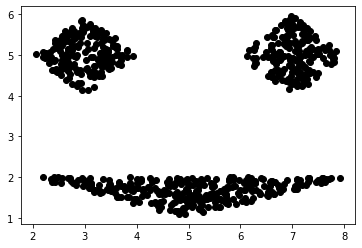

In [5]:
c = df['y'] == 1

plt.plot(df[c].x_1, df[c].x_2, 'ko')
#plt.plot(df[~c].x_1, df[~c].x_2, 'ro')
plt.show()

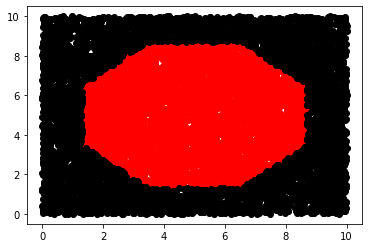

In [6]:
center = [5, 5]
r = 4

offset = -np.pi / 8 + .00001

points = r * np.array([[np.cos(i * np.pi / 4 + offset), np.sin(i * np.pi / 4 + offset)] for i in range(9)]) + center

inequalities = [[
    Inequality(get_slope_line(points[i], points[i+1]).y, '<' if i < 4 else '>') for i in range(8)
]]

df = generate_points(10000, inequalities)

c = df['y'] == 1

plt.plot(df[c].x_1, df[c].x_2, 'ro')
plt.plot(df[~c].x_1, df[~c].x_2, 'ko')
plt.show()

## 1. Backpropagation

Even though neural networks are not an example of convex optimization,
it has still proven useful to train the networks via stochastic gradient
descent (SGD). Even if the found minima are only local or not even
minima, this does not preclude their usefulness.

Let $f(x, W)$ be the output of the neural net with weights $W$ at
the input $x$. Previously, we had normalized the output by using the
sign function to map to $\pm1$. In this case we will not do this, leaving
the output layer to have the identity function as its activation function.
Since the desired values are $\pm1$, we will stick with the hinge loss,
which is defined as $\ell(x, y, W) = \max\{0, 1 - y f(x, W)\}$. As before,
if $1 - y f(x, W) \leq 0$, i.e., if the correct sign is being predicted,
then the hinge loss has the zero vetor as a subgradient (with respect to
$W$). Otherwise a subgradient is $- y\partial_W f(x, W)$. Thus in the 
update step we have to calculate the gradient of the neural network with
respect to the weights.

The backpropagation algorithm is used to calculate this gradient. As noted in 
the [activation functions](https://kevinnowland.com/code/2020/04/19/activation-functions.html)
post, feed forward neural networks are compositions of affine linear 
transformations (of which the weights are parameters) and component-wise 
activation functions. The structure of the composition suggests the
backpropagation algorithm, where derivatives with respect to the weights
in layers closer to the output layer can be used to calculate the
derivatives with respect to weights closer to the input layer.
The backpropagation algorithm actually consists of two parts, a forward
pass through the neural network to calculate inputs and outputs of
each layer and the backward pass to calculate the components of the
gradient.

I'm going to upgrade the `SimpleNN` class I used previously to work in
layers.

In [1048]:
# here are some activation functions and derivatives we might use
def const(x):
    if type(x) == np.ndarray:
        return np.ones(x.shape)
    elif type(x) == list:
        return np.ones(len(x))
    else:
        return 1
    
def const_prime(x):
    if type(x) == np.ndarray:
        return np.zeros(x.shape)
    elif type(x) == list:
        return np.zeros(len(x))
    else:
        return 0
    
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1-sigmoid(x))

def elu(x, a=0.01):
    return x * (x>0) + a * (np.exp(x) - 1) * (x<=0)

def elu_prime(x, a=0.01):
    return 1 * (x>0) + a * np.exp(x) * (x<=0)

def relu(x):
    return elu(x, 0)

def relu_prime(x):
    return elu_prime(x, 0)

def sign(x):
    return 1 * (x > 0) + -1 * (x <= 0)

In [1133]:
class Neuron():
    """ a neuron with an activation function and its derivative """
    def __init__(self, sigma, sigma_prime):
        self._sigma = sigma
        self._sigma_prime = sigma_prime
        
    @property
    def sigma(self):
        return self._sigma
    
    @property
    def sigma_prime(self):
        return self._sigma_prime
        
    def __str__(self):
        return "Neuron()"
    
class Layer():
    """ a layer of a neural network. The layer assumes that
    every neuron has the same activation function except
    for potentially a constant neuron at the end. If
    being used as an input layer, sigma_prime can be
    left as None. If has_const==True, then the nth
    neuron will be the constant neuron"""
    
    def __init__(self, n, sigma, sigma_prime=None, has_const=False):
        self._neurons = [Neuron(sigma, sigma_prime) for i in range(n)]
        self._has_const = has_const
        
        if has_const:
            self._neurons[-1] = Neuron(const, const_prime)
        
    def __str__(self):
        return "Layer() of {} neurons".format(self.width)
    
    def __repr__(self):
        return self.__str__()
    
    @property
    def neurons(self):
        return self._neurons
    
    @property
    def has_const(self):
        return self._has_const
    
    @property
    def width(self):
        return len(self._neurons)
        
    def output(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma(x[i]) for i in range(len(x))])
    
    def output_prime(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma_prime(x[i]) for i in range(len(x))])
        
class NeuralNet():
    """ a neural net that is constructed from the layers
    it is given. Should be given both an input layer 
    and an output layer. Weights will be initialized
    with the proper shape, but as all ones and zeros. They
    can either be initiated using the function included
    here or set by hand.
    
    With T hidden layers, we have T+2 layers of neurons
    as we have the input and output layers. There are only
    T+1 layers of weights, however, as there are no
    weights from the output layer.
    
    We're going to initialize with Kaiming initializaiton.
    If non-ReLU / ELU is used, set w by hand before training."""
    
    def __init__(self, layer_list, check_w_before_set=True, random_seed=None):
        np.random.seed(random_seed)
        
        self._layers = layer_list
        self._checks = check_w_before_set
        
        def get_layer_architecture(l, l_next):
            arch = np.ones(shape=(l_next.width, l.width))
            if l_next.has_const:
                arch[-1,:] = 0
            return arch
            
        self._architecture = [
            get_layer_architecture(self._layers[i], self._layers[i+1])
            for i in range(len(self._layers) - 1)
        ]
        
        self._w = [
            np.random.normal(0, np.sqrt(2.0 / a.shape[1]), size=a.shape) * a
            for a in self._architecture
        ]
        
    def __str__(self):
        num_hidden = len(self._layers) - 2
        width = np.max([l.width for l in self._layers])
        return "NeuralNet() with {0} hidden layer(s) and width {1}".format(num_hidden, width)
        
    @property
    def layers(self):
        return self._layers
    
    @property
    def architecture(self):
        return self._architecture
        
    @property
    def w(self):
        return self._w
    
    @property
    def check_w_before_set(self):
        return self._checks
    
    def _check_architecture(self, w, a):
        """checks that w has zeros wherever a does """
        inds = np.where(a==0)
        if len(inds[0]) == 0:
            return True
        else:
            return all([w[inds[0][i], inds[1][i]] == 0 for i in range(len(inds[0]))])
    
    @w.setter
    def w(self, w_val):
        if self._checks:
            # check that w_val has proper sizes
            assert len(w_val) == len(self._w), "proposed w has bad length"
            assert all([w_val[i].shape == self._w[i].shape for i in range(len(self._w))]), \
                "proposed w has bad shapes somewhere"
            assert all([self._check_architecture(w_val[i], self._architecture[i]) for i in range(len(self._w))]), \
                "proposed w has bad architecture"
        self._w = w_val
        
    def copy_weights(self):
        return [w.copy() for w in self._w]
        
    def _clean_x(self, x):
        """ take data of form (n_samples, n_features)
        that is either a pandas DataFrame, list, or numpy array
        and add a row of 1s then convert to a numpy array and
        transpose. """
        if type(x) == np.ndarray:
            # check if it's already clean
            if x.shape[0] == self._layers[0].width:
                if (x[-1,:] == 1).all():
                    return x
            else:
                return np.append(x, np.ones((x.shape[0], 1)), axis=1).transpose()
        elif type(x) == pd.DataFrame:
            xx = x.copy()
            xx['const'] = 1
            return xx.values.transpose()
        elif type(x) == list:
            return np.array([row + [1] for row in x]).transpose()
    
    def _clean_y(self, y):
        """ take a column vector and make sure it's a numpy column vector """
        if type(y) == np.ndarray:
            return y.reshape(-1, 1)
        elif type(y) == pd.Series:
            return y.values.reshape(-1, 1)
        elif type(y) == list:
            return np.array(y).reshape(-1, 1)
        
        
    def raw_output(self, x):
        """ gets the raw output of the neural network
        
        x needs to have shape (n_samples, n_features)
        without the constant feature appended."""
        
        raw_output, _, _ = self._forward_pass(self._clean_x(x))
        
        return raw_output
    
    def predict(self, x):
        """ gets the -1 or +1 prediction of the neural network """
        return sign(self.raw_output(x))
    
    def _forward_pass(self, x):
        """ forward pass through the neural network recording
        the outputs and inputs as we go. As an internal
        function, the input x will already be an numpy array
        with shape (n_features+1, n_smples). The +1 is
        for the constant feature."""
        
        # every layer has an input
        a = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
                
        # every layer has an output
        o = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
        
        a[0] = x
        o[0] = self._layers[0].output(a[0])
        
        for i in range(1, len(self._layers)):
            a[i] = np.matmul(self._w[i-1], o[i-1])
            o[i] = self._layers[i].output(a[i])
        
        raw_output = o[-1].transpose()
        
        return raw_output, a, o
    
    def _backward_pass(self, a, o, y):
        """ backward pass through the neural network
        using the forward pass results to calculate the gradient
        as well as the true values which in this case
        are +1 or -1 only. y should be a row vector of
        these values with the same number of columns
        as a[-1] and o[-1], which should have indenticial shapes.
        
        The output is the average gradient for the samples given."""
        
        num_samples = y.shape[1]
        
        # first calculate the sigma_prime values for each hidden + output layer
        sigma_prime = [None] + \
            [self._layers[i].output_prime(a[i]) for i in range(1, len(self._layers))]
        
        # now we start the backward pass for real
        delta = [None] + [np.zeros(a[i].shape) for i in range(1, len(self._layers))]
        z = 1 - y * o[-1]
        delta[-1] = z * (z>0)
        
        for i in range(-2, -len(delta)-1, -1):
            # this is w[i+1] bc len(w) = len(delta) - 1
            delta[i] = np.matmul(self._w[i+1].transpose(), (sigma_prime[i+1]) * delta[i+1])
        
        # calculate the average gradient across all samples
        return [
            np.matmul((sigma_prime[i+1] * delta[i+1]), o[i].transpose()) / num_samples
            for i in range(len(self._w))
        ]
    
    def fit(self, x, y, eta=0.1, max_iter=1000, 
            max_error=0.1, batch_size=10, 
            save_data=False, random_seed=None):
        """ use stochastic gradient descent with backpropagation
        to fit the network to the given training data x which
        should be of size (n_samples, n_features),
        y should be of size (n_samples, 1)"""
        
        np.random.seed(random_seed)
        
        x_ = self._clean_x(x) # (n_features + 1, n_samples) matrix
        y_ = self._clean_y(y) # column vector
        num_samples = y_.shape[0]
        saved_data = []
        
        w = self.copy_weights()
        
        def calculate_train_error():
            current_predictions = self.predict(x_)
            wrong = np.sum(y_ * current_predictions < 0)
            return 1.0 * wrong / num_samples
        
        num_iter = 1
        train_error = calculate_train_error()
        
        if save_data:
            saved_data = [[num_iter-1, train_error, self.copy_weights()]]
        
        while train_error >= max_error and num_iter <= max_iter:
            
            num_iter += 1
            
            # get samples to use for this batch
            batch_ind = np.random.choice(num_samples, batch_size)
            
            x_batch = x_[:, batch_ind]
            y_batch = y_[batch_ind,:]
            
            # forward pass
            _, a, o = self._forward_pass(x_batch)
            
            # backward pass
            grad = self._backward_pass(a, o, y_batch.transpose())
            
            w = [w[i] - eta * grad[i] for i in range(len(w))]
            self.w = [
                ((num_iter - 1) * self._w[i] + w[i]) / num_iter
                for i in range(len(self._w))
            ]
            
            train_error = calculate_train_error()
            
            if (num_iter - 1) % 10 == 0:
                if save_data:
                    saved_data += [[num_iter-1, train_error, self.copy_weights()]]
            
        if num_iter > max_iter:
            logging.warning("NeuralNet.fit():no convergence, train_error above max_error")
        else:
            logging.warning("NeuralNet.fit(): converged after {} iterations.".format(num_iter-1))
        
        if save_data:
            return saved_data
        else:
            return None
        

Finally, let's train.

In [1142]:
input_layer = Layer(3, lambda x: x, None, True)
hidden_layer = Layer(2, relu, relu_prime, False)
output_layer = Layer(1, lambda x: x, const, False)

#
nn = NeuralNet([input_layer, hidden_layer, output_layer], random_seed=65)

lines = [SlopeLine(1, 0), SlopeLine(-1, 10)]
ineqs = [Inequality(lines[0].y, '<'), Inequality(lines[1].y, '<')]

train_data = generate_points(1000, [ineqs])

train_data['prediction_before'] = nn.predict(train_data[['x_1', 'x_2']])

data = nn.fit(train_data[['x_1', 'x_2']], train_data['y'], eta=.002, max_iter=1001, max_error=0.1, random_seed=47, save_data=True, batch_size=20)

#for i in range(len(data)):
#    print('{0} - {1:.2f}'.format(data[i][0], data[i][1]))
    
train_data['prediction_after'] = nn.predict(train_data[['x_1', 'x_2']])

print(data[-1][1])

0.268


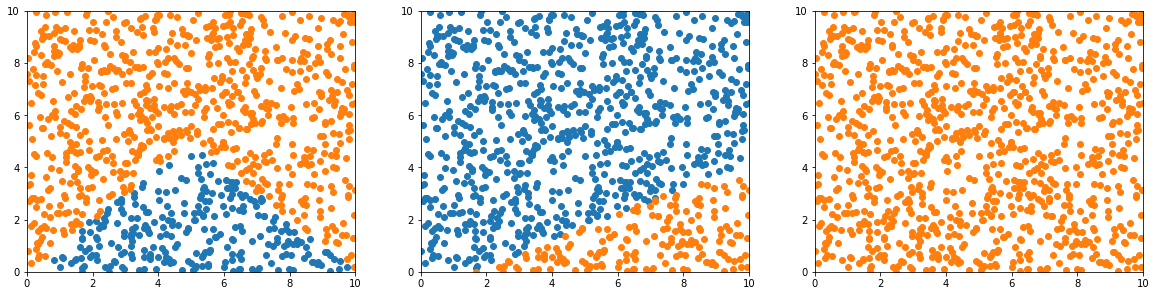

In [1143]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4.8))
lims = np.array([0, 10])

ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[1].set_xlim(lims)
ax[1].set_ylim(lims)
ax[2].set_xlim(lims)
ax[2].set_ylim(lims)

c_tr = train_data['y'] == 1
ax[0].plot(train_data[c_tr]['x_1'], train_data[c_tr]['x_2'], 'o')
ax[0].plot(train_data[~c_tr]['x_1'], train_data[~c_tr]['x_2'], 'o')

c_pr = train_data['prediction_before'] == 1
ax[1].plot(train_data[c_pr]['x_1'], train_data[c_pr]['x_2'], 'o')
ax[1].plot(train_data[~c_pr]['x_1'], train_data[~c_pr]['x_2'], 'o')

c_pr = train_data['prediction_after'] == 1
ax[2].plot(train_data[c_pr]['x_1'], train_data[c_pr]['x_2'], 'o')
ax[2].plot(train_data[~c_pr]['x_1'], train_data[~c_pr]['x_2'], 'o')

plt.show()

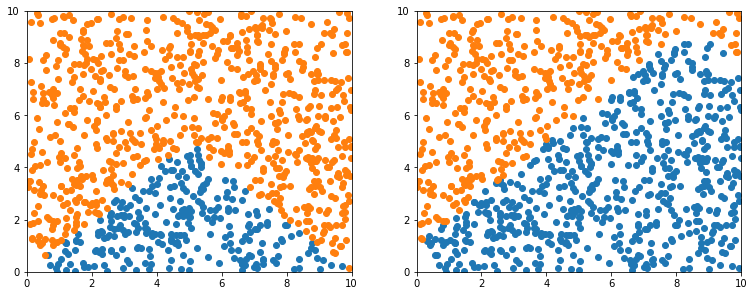

In [1196]:
input_layer = Layer(3, lambda x: x, None, True)
hidden_layer = Layer(2, relu, relu_prime, False)
output_layer = Layer(1, lambda x: x, const, False)

nn_artificial = NeuralNet([input_layer, hidden_layer, output_layer])

# reset to something close to optimal
nn_artificial.w = [
    np.array([[1, -1, 1], [1.8, 0, -15]])
    ,np.array([[1, -1]])
]

lines = [SlopeLine(1, 0), SlopeLine(-1, 10)]
ineqs = [Inequality(lines[0].y, '<'), Inequality(lines[1].y, '<')]

train_data = generate_points(1000, [ineqs])

train_data['prediction'] = nn_artificial.predict(train_data[['x_1', 'x_2']])

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
lims = np.array([0, 10])

ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[1].set_xlim(lims)
ax[1].set_ylim(lims)

c_tr = train_data['y'] == 1
ax[0].plot(train_data[c_tr]['x_1'], train_data[c_tr]['x_2'], 'o')
ax[0].plot(train_data[~c_tr]['x_1'], train_data[~c_tr]['x_2'], 'o')

c_pr = train_data['prediction'] == 1
ax[1].plot(train_data[c_pr]['x_1'], train_data[c_pr]['x_2'], 'o')
ax[1].plot(train_data[~c_pr]['x_1'], train_data[~c_pr]['x_2'], 'o')

plt.show()

In [1197]:
data = nn_artificial.fit(train_data[['x_1', 'x_2']],
                        train_data['y'],
                        eta=.001,
                        max_iter=1001,
                        max_error=0.05,
                        random_seed=4,
                        save_data=True,
                        batch_size=20)

print(data[0][1])
print(data[-1][1])

0.352
0.157


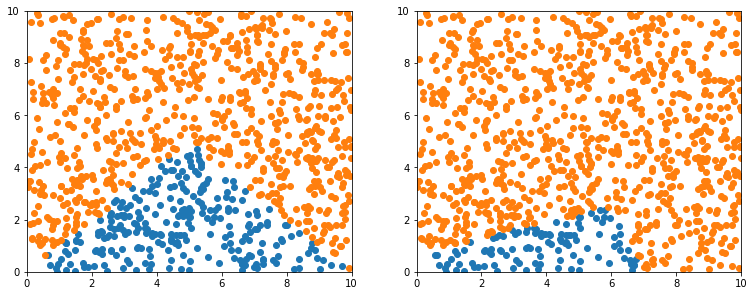

In [1198]:
train_data['prediction'] = nn_artificial.predict(train_data[['x_1', 'x_2']])

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
lims = np.array([0, 10])

ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[1].set_xlim(lims)
ax[1].set_ylim(lims)

c_tr = train_data['y'] == 1
ax[0].plot(train_data[c_tr]['x_1'], train_data[c_tr]['x_2'], 'o')
ax[0].plot(train_data[~c_tr]['x_1'], train_data[~c_tr]['x_2'], 'o')

c_pr = train_data['prediction'] == 1
ax[1].plot(train_data[c_pr]['x_1'], train_data[c_pr]['x_2'], 'o')
ax[1].plot(train_data[~c_pr]['x_1'], train_data[~c_pr]['x_2'], 'o')

plt.show()

## Backpropagation Details

Let's recall the setup. We have a layer $V_t$ of $n_t$ neurons. The
input to $V_t$ is $a_t$ and the output is $o_t = \sigma_t(a_t)$. 
Also, $a_t = W^{t-1}o_{t-1}$, and $W^{t-1}$ is a matrix of size
$n_t\times n_{t-1}$. The activation function $s_t$ will act
componentwise on the $n_t$-dimensional vector $a_t$. $W^0$ is the
weights from the input layer, and $W^T$ is the weights from
the last hidden layer to the output layer, which consists of a single neuron
that has the identity function as its activator.

Let's examine how (the positive part of) the loss $\ell(x, y, W)=1-y f(x, W)$ 
depends on $w^T_k$, a weight from the last hidden layer to the output
layer. We calculate

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^T_k}}
    &= \frac{\partial}{\partial{w^T_k}}(1 - y\sigma_{T+1}'(W^To_T)) \\
    &= -y \sigma_{T+1}'(a_{T+1})o_{T-1, k}.
\end{align*}
$$

We get the $o_{T-1, k}$ term because $a_{T+1}=W^To_T = \sum_i w^T_i o_{T, i}$.
Now let's consider the weight $w^T_{k, n}$ from neuron $n$ in $V_{T-1}$ 
to neuron $k$ in $V_T$. For this partial derivative we first find that

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^{T-1}_{k, n}}}
    &= \frac{\partial}{\partial{w^{T-1}_{k, n}}}(1 - y \sigma_{T+1}(W^T\sigma_T(W^{T-1}o_{T-1}))) \\
    &= -y \sigma_{T+1}'(a_{T+1})\frac{\partial}{\partial{w^{T-1}_{k, n}}} W^T\sigma_T(W^{T-1}o_{T-1})
\end{align*}
$$

Stopping for a moment to consider this, $w^{T-1}_{k, n}$ only feeds neuron $k$ in $V_T$,
so only the $k$th component of $\sigma_T$ is affected. Since the output layer only has one neuron,
the only weight from this neuron is $w^T_k$, so we end up with

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^{T-1}_{k, n}}}
    &= -y \sigma_{T+1}'(a_{T+1}) w^T_k \sigma_{T, k}'(a_T) o_{T-1, n}.
\end{align*}
$$

Note that we've repeated $-y\sigma_{T+1}'(a_{T+1})$. Let's get a little ahead 
of ourselves define

$$
    \delta_{T+1} := -y, \quad
    \delta_{T, k} := \delta_{T+1,k}\sigma_{T+1}'(a_{T+1})w^T_k.
$$

Such that

$$
    \frac{\partial\ell}{\partial{w^T_k}} = \delta_{T+1}\sigma_{T+1}'(a_{T+1})o_{T-1, k},\quad
    \frac{\partial\ell}{\partial{w^{T-1}_{k, n}}} = \delta_T\sigma_{T, k}'(a_T) o_{T-1, n}.
$$

This already shows how backpropogation might work. A first forward pass through the neural
net is necessary to calculate the $a_i$ and $o_i$, while on the backward pass we
calculate the derivates one layer at a time, from output to input, storing the $\delta$
values along the way to help calculate successive derivatives. However, since the output
layer only has one neuron, it's a little bit cheating to say that we are done, so
let's calculate a derivative with respect to $w^{T-2}_{n, m}$ to get the full scope of
the behavior. What changes here is that while $w^{T-2}_{n, m}$ only feeds neuron $n$
in $V_{T-1}$, but neuron $n$ in $V_{T-1}$ feeds every neuron in $V_T$, of which there are
multiple. So now the calculate looks like

$$
\begin{align*}
    \frac{\partial\ell}{\partial{w^{T-2}_{n, m}}}
    &= -y \sigma_{T+1}'(a_{T+1})\sum_{i=1}^{n_T}w^T_i\sigma_{T, i}'(a_T)w^{T-1}_{i, n}\sigma_{T-1, n}'(a_{T-1})o_{T-2, m} \\
    &= \sum_{i=1}^{n_T}\delta_{T, i}\sigma_{T, i}'(a_T)w^{T-1}_{i, n}\sigma_{T-1, n}'(a_{T-1})o_{T-2, m}.
\end{align*}
$$

Therefore we define

$$
    \delta_{T-1, n} = \sum_{i=1}^{n_T}\delta_{T, i}\sigma_{T, i}'(a_T)w^{T-1}_{i, n}
$$

such that

$$
    \frac{\partial\ell}{\partial w^{T-2}_{n, m}} = \delta_{T-1, n}\sigma_{T-1, n}'(a_{T-1})o_{T-2, m}.
$$

What we've shown is that the backward pass can be summarized by

$$
\begin{align*}
    \delta_{T+1} &= -y, \\
    \delta_{t} &= {}^TW^t(\sigma_{t+1}'(a_{t+1})*\delta_{t+1}), \\
    \frac{\partial\ell}{\partial w^t} &= (\sigma_{t+1}'(a_{t+1})*\delta_{t+1})({}^To_t),
\end{align*}
$$

where ${}^TA$ is the transpose of $A$ and $(x*y)$ is the elementwise product. Looking
at the structure of the recursion, it becomes clear what each component is. 
The $\delta_{t+1}$ vectors hold the information for all derivatives beyond (closer to the
output) layer $t+1$. Then $\sigma'_{t+1}$ encodes the derivatives at
layer $t+1$. Since the activation functions at a layer act diagonally (for now), 
you can take the elementwise product, as
you would get a diagonal matrix for the Jacobian of activation functions.
Then, the input $a_{t+1}$ that feeds into layer $t+1$ depends has
the form $W^to_t$. If you want to go another layer down the network before taking
a derivative with respcet to the weights at a lower layer, you have to take the
derivative with respect to $o_t$ and you end up with a $W^t$ term. Since you are
going from a layer that has size $n_{t+1}$ to a layer of size $n_t$ you need
a matrix of sixe $n_t\times n_{t+1}$, which is why you get ${}^TW_t$. 
Similarly, if you are at the layer you want and are taking the derivative with
respect to $W^t$, then you end up with ${}^To_t$ instead.

In other words, we are taking derivatives of the loss due to layer
$t+1$, which we can denote $\ell_{t+1}$ which takes in $\sigma_{t+1}$
which in turn has $W^to_t$ as its input. If we are goign further
down the chain through $\ell_t$ we need a derivative with respect to
$o_t$, if not we take a derivative with respect to $W^t$.
So we have decomposed the loss $\ell$ as $\ell = \ell_{T+1}\circ\ell_T\circ\cdots$
where each step looks like
$
 \ell_{t+1}(\sigma_{t+1}(W^to_t)).
$

The recursive formula also tells us how we would need to edit backpropagation
if we change the form of the neural net. If the mapping between spaces is no
longer linear, than the $o_t$ and $W^t$ terms would change depending on the
function used. If the activation functions were no longer elementwise,
then instead of $\s_{t+1}'$ we would need a full Jacobian matrix.
This procedure also begs the question of what should be done if the 
activation functions are not differentiable / do not have a well-defined
subgradients. Although practically, piece-wise differentiability should
suffice.

Just what sort of generalizations would be useful would be the big question.
Currently, as someone building up intuition from scratch, I'd say that 
the reason we stick with linear mappings and elementwise activators is that
it's hard to understand anything more complex. Putting anything more complicated
in represents a form of prior knowledge of bias. Without that, it should
always be effective -- given a sufficiently long training period -- to 
increase the width and depth, as it seems from our investigations in the
activation functions notebook that this is all we need in order to represent
more complex functions. It has been remarked that all of mathematics is time
spent reducing to linear operations, and this is yet another example of that
phenomenon.